# OSU Micro Benchmarks (OMB)

Results of selected latency and bandwidth tests from the [OMB suite](http://mvapich.cse.ohio-state.edu/benchmarks/).

All these tests use two nodes:

- `osu_bw`: Single process per node
- `osu_latency`: Single process per node
- `osu_bibw` (bidirectional bandwidth test): Single process per node
- `osu_allgather`, `osu_allreduce`, `osu_alltoall` (MPI blocking collective tests): As many processes per node as physical cores
- `osu_mbw_mr` (multiple bandwidth / message rate test): Varying numbers of processes per node, communicating in pairs split across nodes

In [10]:
# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import display, Markdown

import pandas as pd
import os, sys
from pprint import pprint
sys.path.extend(('../../reframe', '../../')) # the `modules` package imports `reframe` so need that in sys.modules
import modules

# Single process per node: Bandwidth & latency vs message size

The plots below show results vs message size for tests using a single process per node. Results are for the most-recent test on each system/partition/environment combination.

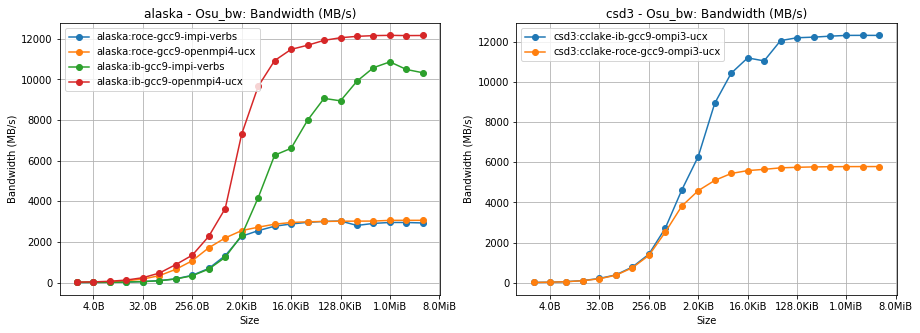

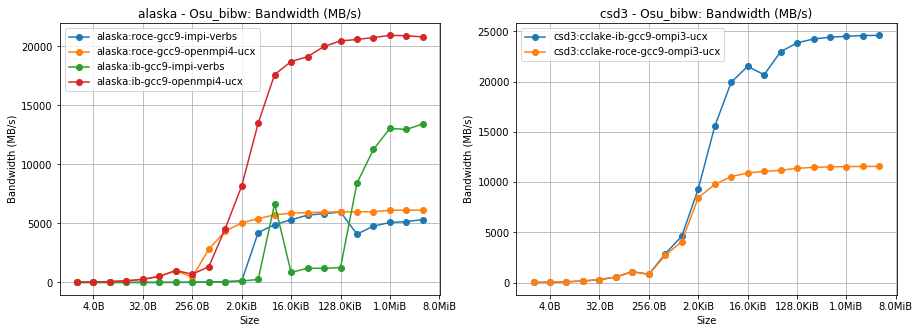

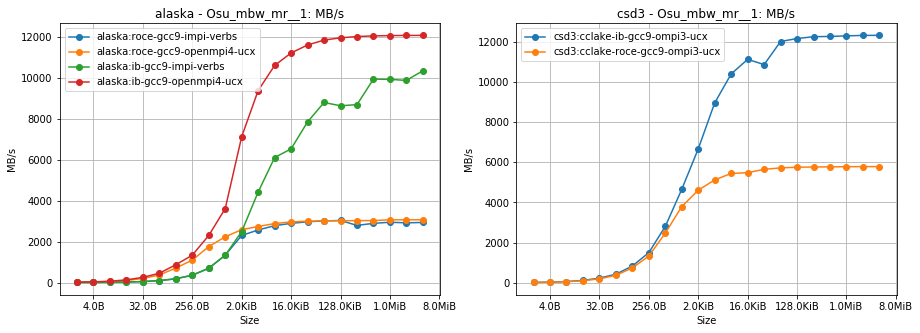

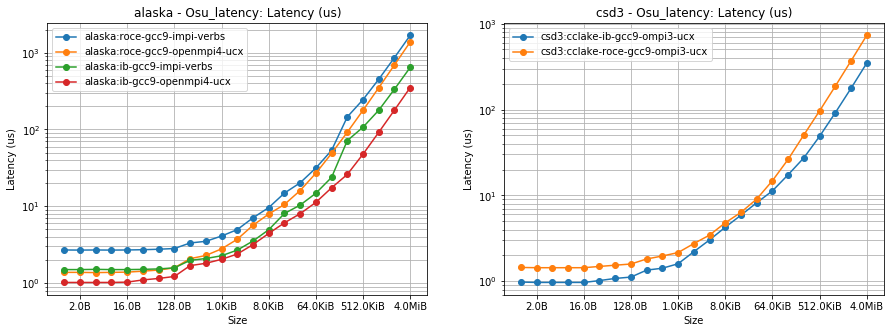

In [2]:
for test in ['Osu_bw', 'Osu_bibw',
             'Osu_mbw_mr__1', # -1 to specify 1x process/node => "_1" in reframe test title
             'Osu_latency']:
    
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    systems = sorted(set(m['sysname'] for m in meta))
    fig, axes = plt.subplots(nrows=1, ncols=len(systems), figsize=(15, 5))
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.omb.read_omb_out(path)
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        ax_idx = systems.index(meta[ix]['sysname'])
        axes[ax_idx].plot(data.columns[0], data.columns[1], 'o-', data=data, label=label)
        
    # format plot:
    for ax_ix, ax in enumerate(axes):
        ax.set_xscale('log', basex=2)
        if 'latency' in data.columns[1].lower():
            ax.set_yscale('log', basey=10)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
        ax.grid(True, which="both")
        ax.set_xlabel(data.columns[0])
        ax.set_ylabel(data.columns[1])
        ax.set_title('%s - %s: %s' % (systems[ax_ix], test, data.columns[1]))
        ax.legend()

# MPI Blocking Collective  Operations: Latency vs message size

The plots below show results vs message size for tests using as many processes per nodes as there are physical cores. Results are for the most-recent test on each system/partition/environment combination.

Values are the mean latency for each message size taken over all pairs of communicating processes.

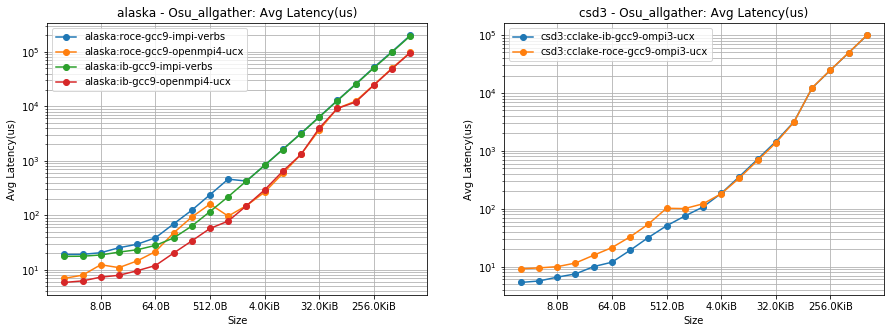

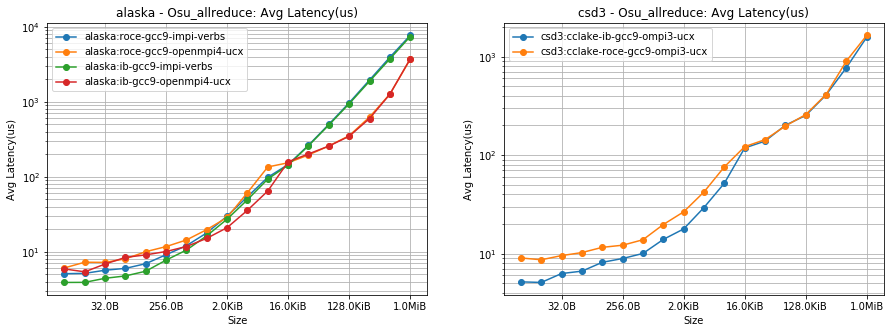

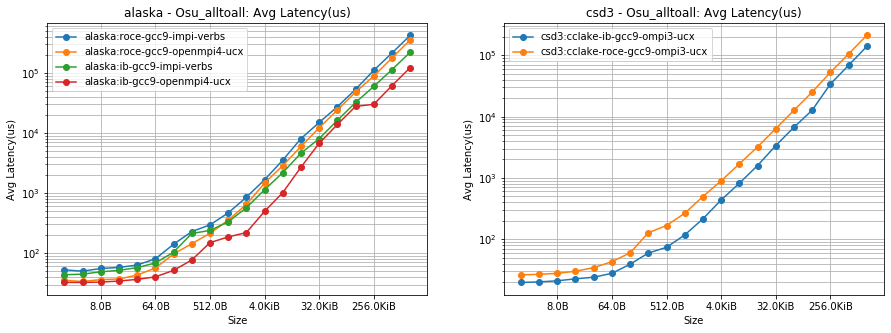

In [3]:
for test in  ['Osu_allgather', 'Osu_allreduce', 'Osu_alltoall', ]:
    # find all data and work out differences between them:
    paths = modules.utils.find_run_outputs(root='../../output', test=test)
    meta = [modules.utils.parse_path_metadata(p) for p in paths]
    systems = sorted(set(m['sysname'] for m in meta))
    fig, axes = plt.subplots(nrows=1, ncols=len(systems), figsize=(15, 5))
    
    # load and plot:
    for ix, path in enumerate(paths):
        data = modules.omb.read_omb_out(path)
        label = '%s:%s' % (meta[ix]['sysname'], meta[ix]['partition'])
        ax_idx = systems.index(meta[ix]['sysname'])
        axes[ax_idx].plot(data.columns[0], data.columns[1], 'o-', data=data, label=label)
        
    # format plot:
    for ax_ix, ax in enumerate(axes):
        ax.set_xscale('log', basex=2)
        ax.set_yscale('log', basey=10)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: modules.utils.sizeof_fmt(x)))
        ax.grid(True, which="both")
        ax.set_xlabel(data.columns[0])
        ax.set_ylabel(data.columns[1])
        ax.set_title('%s - %s: %s' % (systems[ax_ix], test, data.columns[1]))
        ax.legend()

# Max Bandwidth/Message Rate vs Number of Processes per Node

The plots below show the **maximum** bandwidth and message rate for tests using varying numbers of processes per node. Results are for the most-recent test on each system/partition/environment combination.

### max_bandwidth: Osu_mbw_mr

,max
case,
alaska:ib-gcc9-impi-verbs,100.12
alaska:ib-gcc9-openmpi4-ucx,99.14
alaska:roce-gcc9-impi-verbs,98.84
alaska:roce-gcc9-openmpi4-ucx,98.04
csd3:cclake-ib-gcc9-ompi3-ucx,101.10
csd3:cclake-roce-gcc9-ompi3-ucx,92.59


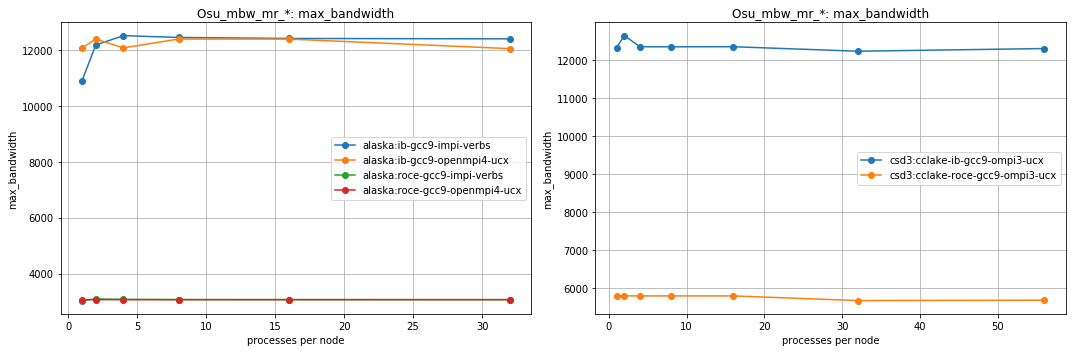

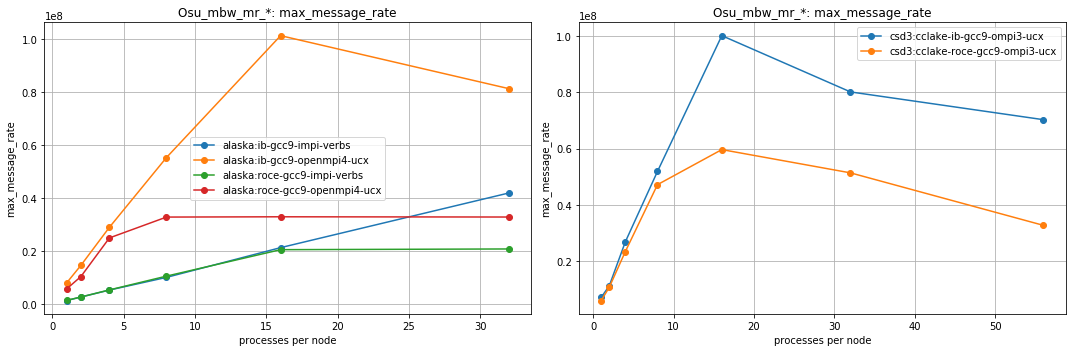

In [15]:
# TODO: needs to be loaded from system config somewhere
Gb_to_MB = 125.0

test = 'Osu_mbw_mr_*'
    
for perf_var in ['max_bandwidth', 'max_message_rate']:
    
    df = modules.utils.tabulate_last_perf(test, 'procs_per_node', perf_var)
    
    # calculate max bandwidth as % of linerate:
    if 'bandwidth' in perf_var:
        display(Markdown('### %s: %s' % (perf_var, test[:-2])))
        maxes = df.max().to_frame('max')
        linerates = [modules.utils.get_sysinfo(syspart)['interconnect_Gb'] * Gb_to_MB * (2 if 'Bi' in test else 1) for syspart in df.columns]
        rates = 100 * maxes.divide(linerates, axis='index')
        display(rates.style.set_caption('Max bandwidth as % of linerate - multiple processes per node').set_precision(2))
    
    # plot by system:
    sys_cols = {} # group columns by system: sysname -> [colA, colB, ...]
    for c in df.columns:
        sysname = c.split(':')[0]
        sys_cols.setdefault(sysname, []).append(c)
    fig, axes = plt.subplots(nrows=1, ncols=len(sys_cols), figsize=(15, 5))
    for sys_idx, (sys, cols) in enumerate(sys_cols.items()):
        sys_df = df.loc[:, cols]
        sys_df.plot(ax=axes[sys_idx], grid=True, style='o-')
    
    # format plot:
    for ix_ax, ax in enumerate(axes):
        ax.set_xlabel('processes per node')
        ax.set_ylabel(perf_var)
        plt.tight_layout()
        ax.set_title('%s: %s' % (test, perf_var))
        ax.legend()
